In [88]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import random


In [6]:
def f(x):
    return 3*x*x -4*x-2

In [7]:
test=np.arange(-1,5,0.25)

In [8]:
test

array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,
        1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,
        3.5 ,  3.75,  4.  ,  4.25,  4.5 ,  4.75])

In [9]:
ys=f(test)
ys

array([ 5.    ,  2.6875,  0.75  , -0.8125, -2.    , -2.8125, -3.25  ,
       -3.3125, -3.    , -2.3125, -1.25  ,  0.1875,  2.    ,  4.1875,
        6.75  ,  9.6875, 13.    , 16.6875, 20.75  , 25.1875, 30.    ,
       35.1875, 40.75  , 46.6875])

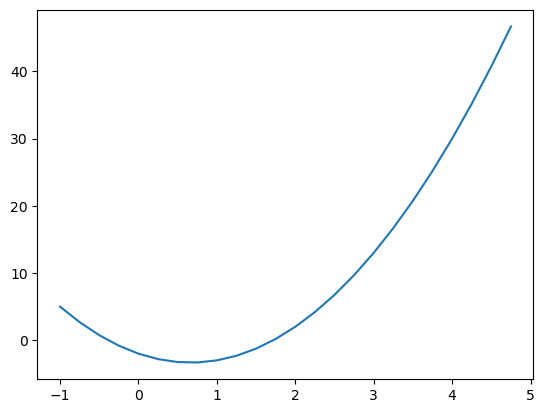

In [10]:
plt.plot(test,ys)

In [11]:
h=0.000001
x=0.001

In [17]:
(f(x+h)-f(x))/h

-3.993996999795968

In [18]:
# les get more complex
# let us think about f(x)=a*x+b
a=5
b=4
x=12
xs=x*a+b


In [23]:
h=0.0001
x=x+h

In [25]:
ys=x*a+b

In [27]:
print("d1",xs)
print("d2",ys)
print("slope",(ys-xs)/h)

d1 64
d2 64.0005
slope 5.000000000023874


In [29]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None  # Initialize _backward as a lambda function
        self.grad = 0
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    

    def __add__(self, other):
        other=other if isinstance(other,Value)else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward  # Assign the function itself, not its result
        return out

    
    def __rmul__(self,other):
        return self*other

    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out=Value(self.data**other,(self,),f'**{other}')

        def _backward():
            self.grad+=other*self.data**(other-1)*out.grad
        out._backward=_backward

        return out

    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad+=out.grad*out.data
        out._backward=_backward
        return out

    

    def __mul__(self, other):
        other=other if isinstance(other,Value)else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward  # Assign the function itself, not its result
        return out


    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward  # Assign the function itself, not its result
        return out


    
    def backward(self):
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad=1.0
        for node in reversed(topo):
            node._backward()
        
        
a=Value(2.0)
b=Value(3.0)
c=Value(10.0)
e=a*b
d=e+c
f=Value(-2.0)
L=d*f

In [31]:
d._prev


{Value(data=10.0), Value(data=6.0)}

In [33]:
d._op

'+'

In [35]:
a=Value(2.0)
b=Value(3.0)
a+1
a*2
a/b

Value(data=0.6666666666666666)

In [37]:
from graphviz import Digraph

def trace(root):
    # bulid a set of all nodes and edges in the graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # lR=left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph , create a rectangular ('record') node for it
        dot.node(name=uid, label="{data%.4f|grad%.4f}" % (n.data,n.grad), shape='record')
        # Access the _op attribute instead of op
        if n._op:  
            # if this value is result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [40]:
L.grad=1.000
c.grad=-2.00
e.grad=-4.00
a.grad=2.00
b.grad=-4.00
d.grad=1.00
f.grad=-1.50


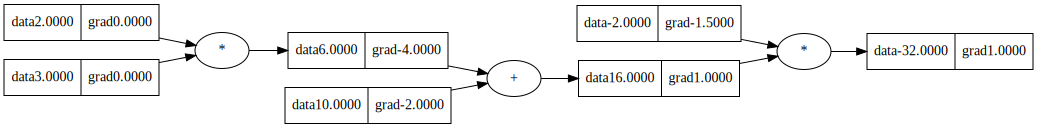

In [43]:
draw_dot(L)


In [45]:
### dl/dc ??
### l=d*f
### d=e+c
### l=(e+c)*f =>dl/dc=d(e+c)*f/dc=d(e*f)/dc+d(c*f)/dc=>f
### c=a*b
### dc/da=b
### dl/da=(dl/dc)*(dc/da)=f*b
### dl/df=d=(c+e)=((a*b)+e)

In [47]:
def lol():
    h=0.0001


    
    a=Value(2.0)
    b=Value(3.0)
    c=Value(10.0)
    e=a*b
    d=e+c
    f=Value(-2.0)
    L=d*f
    L1=L.data

    a=Value(2.0+h)
    b=Value(3.0)
    c=Value(10.0)
    e=a*b
    d=e+c
    f=Value(-2.0)
    L=d*f
    L2=L.data

    print((L2-L1)/h)
    

In [49]:
lol()

-6.000000000057071


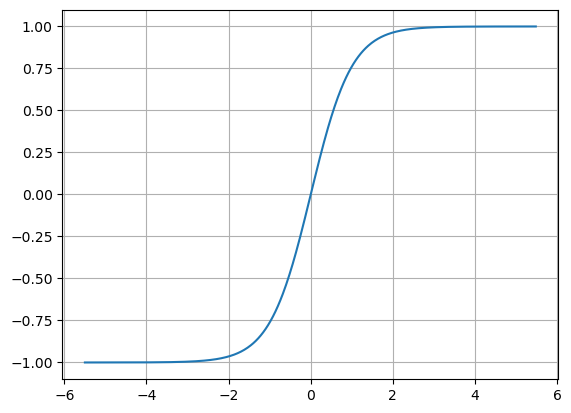

In [51]:
plt.plot(np.arange(-5.5,5.5,0.02),np.tanh(np.arange(-5.5,5.5,0.02)));
plt.grid()

In [53]:
## inputs
x1=Value(2.0)
x2=Value(0.0)
## weight of neuron
w1=Value(-3.0)
w2=Value(-4.0)
## bais of the nueron
b=Value(6.881373587)
## x1w1+x2w2+b
x1w1=x1*w1
x2w2=x2*w2
x1w1x2w2=x1w1+x2w2
n=x1w1x2w2+b
o=n.tanh()
o.grad=1.0
#### By creadting function: 
# o._backward()
# n._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()
## Manually finding all the value
# o.grad=1.00
# n.grad=0.5
# x1w1x2w2.grad=0.5
# b.grad=0.5
# x1w1.grad=0.5
# x2w2.grad=0.5
# x2.grad=-4.0*0.5
# w2.grad=0.00*0.5
# x1.grad=-3.0*0.5
# w1.grad=2.0*0.5


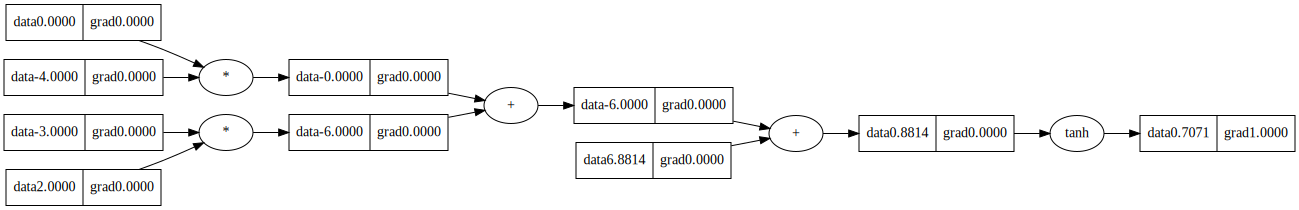

In [55]:
draw_dot(o)

In [57]:
o.backward()

In [59]:
o.grad=1.0

In [61]:
topo=[]
visited=set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
for node in reversed(topo):
    node._backward()


In [63]:
### z=tanh(x)=(e^2x-1)/(e^2x+1), Now d(tanh(x))/dx=(2*e^2x)/(e^2x+1)+(e^2x-1)*(((-1)*(2*e^2x))/(e^2x+1)^2)
### => ((2*e^2x)*(e^2x+1)-(2*e^2x)*(e^2*x-1))/(e^2x+1)^2=> (4*e^2x)/(e^2x+1)^2
### d(tanh(x))/dx=(4*e^2x)/((e^2x+1)^2)=1-(tanhx)^2

In [65]:
o.data

0.7071067811767758

In [67]:
1-(o.data)**2

0.5000000000138193

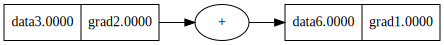

In [69]:
a=Value(3.0)
b=a+a;
b.backward()
draw_dot(b)

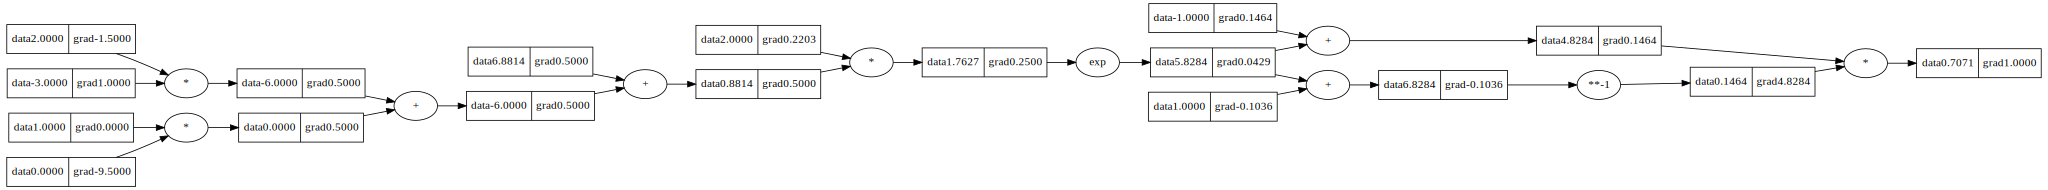

In [71]:
x1=Value(2.0)
X2=Value(0.0)
## weigh w1,w2
w1=Value(-3.0)
w2=Value(1.0)

## bais of the neuron
b=Value(6.881373587019)

x1w1=x1*w1
x2w2=x2*w2

x1w1x2w2=x1w1+x2w2
n=x1w1x2w2 + b

###-----###

e= (2*n).exp()
o=(e-1)/(e+1)

###-----###

o.backward()
draw_dot(o)


In [215]:
class Neuron:
    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))
    def __call__(self,x):
        #w*x+b
        act=sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out=act.tanh()
        return out
    def parameters(self):
        return self.w+[self.b]
        
class Layer:

    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)== 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
x=[2.0,3.0]
n=Neuron(2)
n(x)

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
x=[2.0,3.0,-1.0]

n=MLP(3,[4,4,1])
n(x)

Value(data=-0.3568786207468508)

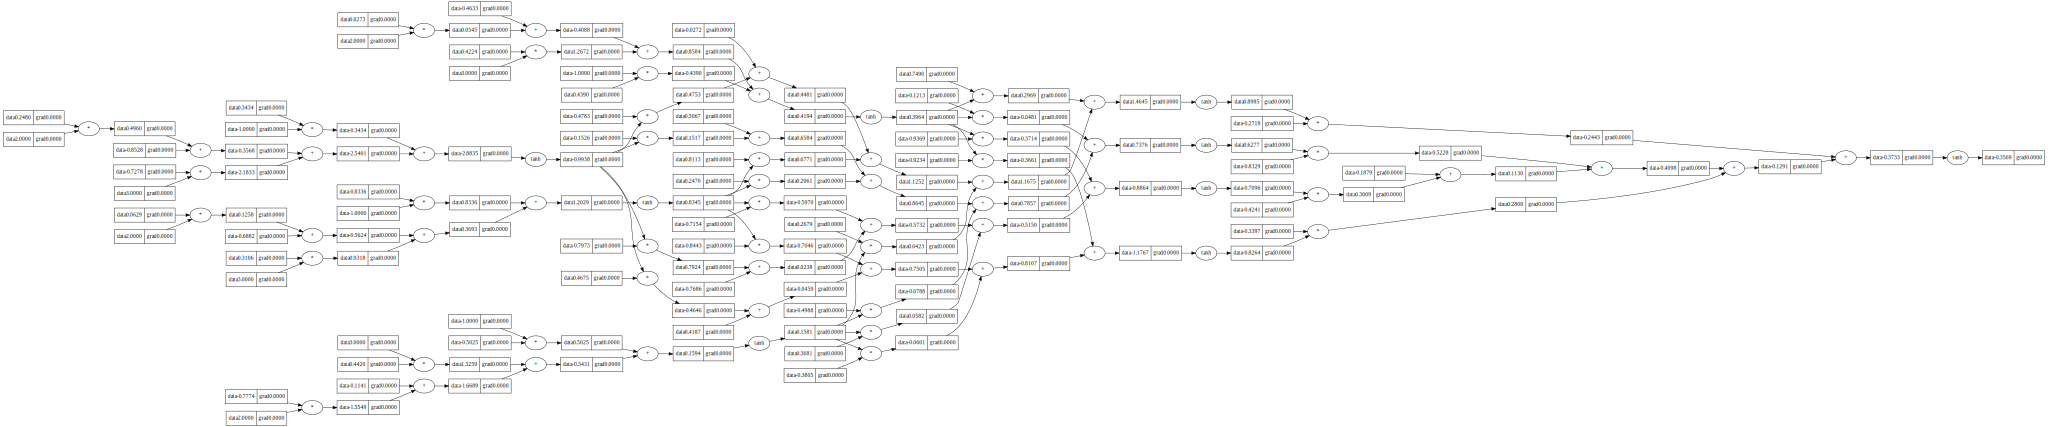

In [217]:
draw_dot(n(x))

In [218]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred=[n(x) for x in xs]
ypred

[Value(data=-0.3568786207468508),
 Value(data=-0.5251143032149403),
 Value(data=-0.6355979384128012),
 Value(data=-0.7005109351101072)]

In [221]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))  
# Start with a Value(0.0) object as the initial value for sum
loss

Value(data=5.09116231936896)

In [223]:
loss.backward()

In [225]:
n.layers[0].neurons[0].w[0].grad


0.3313713594716246

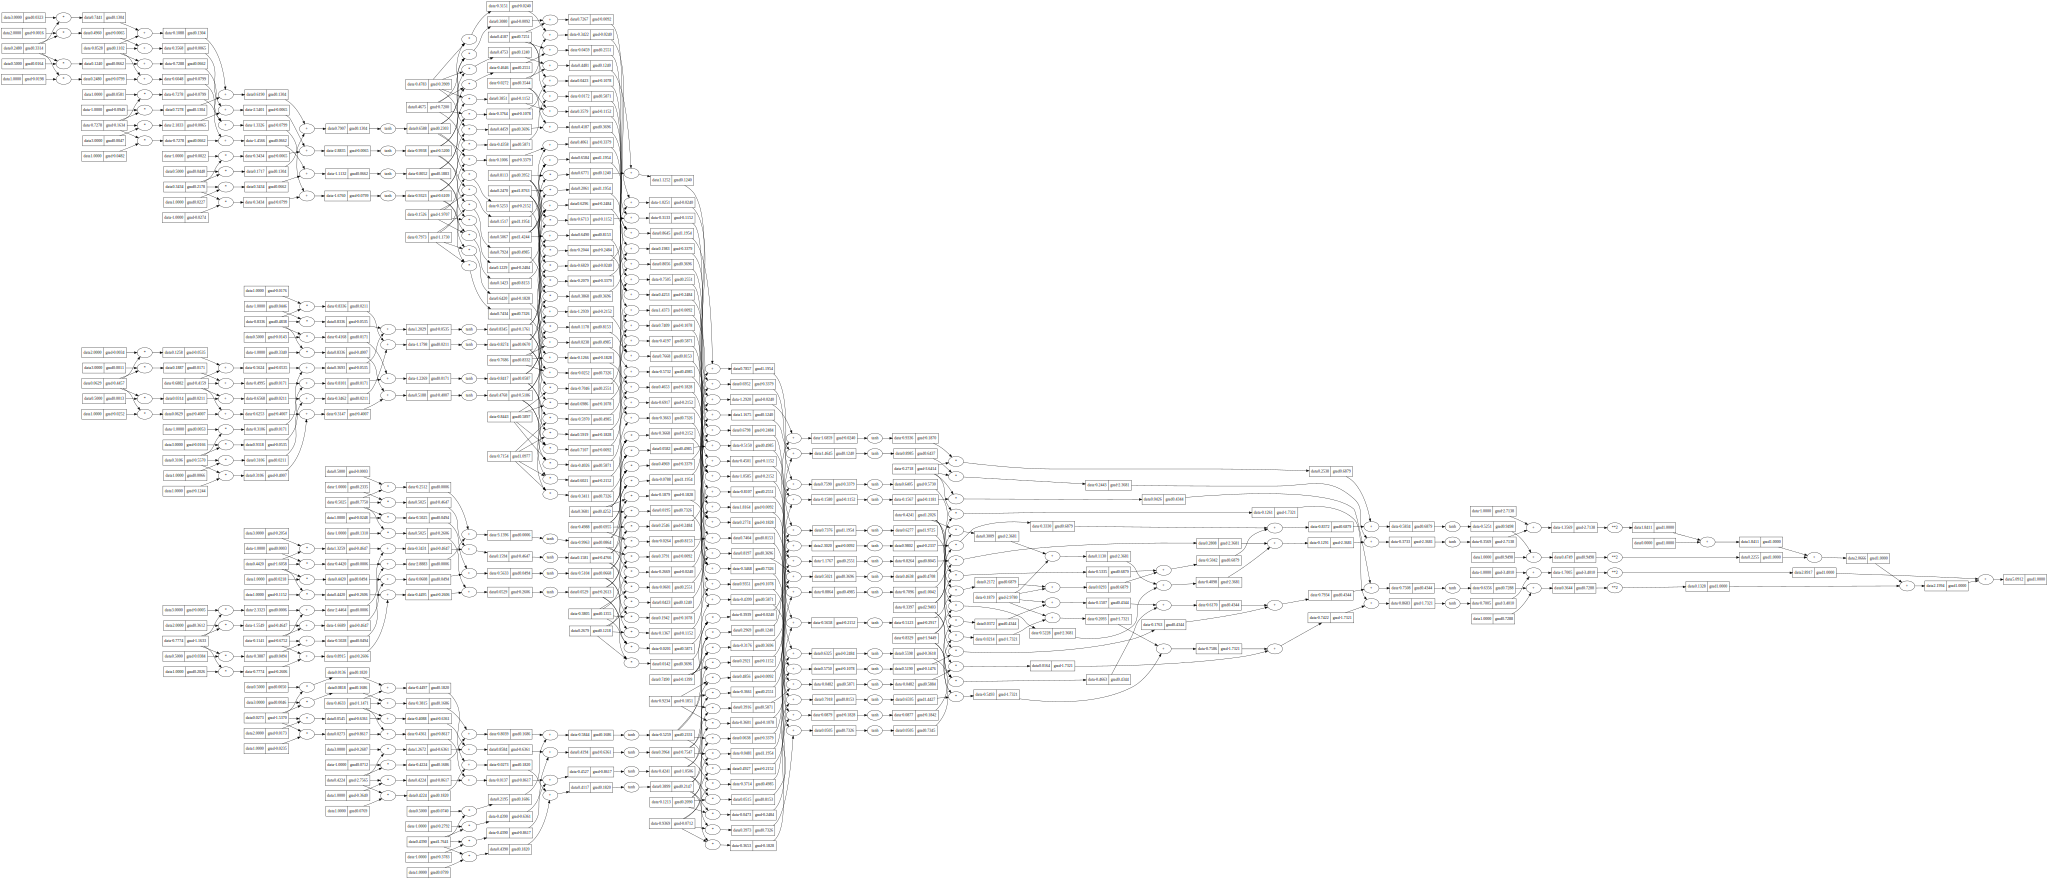

In [227]:
draw_dot(loss)

In [228]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))  
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update 
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(k, loss.data)

0 5.09116231936896
1 1.658766541614313
2 0.6226936616303663
3 0.3324396801508357
4 0.2216683848306118
5 0.16222775203732132
6 0.12614447348034855
7 0.10228594752830508
8 0.08550595335337816
9 0.07314463826474144
10 0.06370539877092997
11 0.05628845210848811
12 0.05032341023552979
13 0.04543272802725819
14 0.041357376105720954
15 0.03791418079273659
16 0.0349702217182107
17 0.032426870245074464
18 0.03020950606510613
19 0.028260699654984983
